In [2]:
from cells.bind import VertexModel

import os
import sys
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
from operator import itemgetter
from glob import glob
from tqdm import tqdm

sys.path.append("analysis/utils/")
import config_functions   as config
import vm_output_handling as vm_output
from correlation_object import VMAutocorrelationObject

In [3]:
#filename = "nodivision_20251120_1.p"

#filepath = f"data/simulated/raw/nodivision_20251120_N42_L600_gamma7_v040_taup140_eta0.p"
filepath = f"data/experimental/processed/holomonitor_20240301_B1-4"

autocorr = VMAutocorrelationObject(out_path=filepath)
autocorr.log

No saved state file found at data/simulated/processed/data/experimental/processed/holomonitor_20240301_B1-4.autocorr. Starting fresh with provided data.


{'t': {}, 'r': {}}

In [ ]:
config_dir = "data/simulated/configs/"
config_path = f"{config_dir}{Path(filepath).stem}.json"
config_file = config.load(config_path)

# Compute time period between frames
dt = config_file["simulation"]["dt"]
T  = config_file["simulation"]["period"]
df = T * dt

# Load frames as vm objects
list_vm, init_vm = vm_output.load(filepath, df=df)


In [51]:
cell_heights    = vm_output.get_cell_heights(list_vm)
cell_volumes    = vm_output.get_cell_volumes(list_vm)
cell_velocities = vm_output.get_cell_velocities(list_vm)

cell_areas      = cell_volumes / cell_heights
cell_speeds     = np.sqrt(cell_velocities[:,:,0]**2 + cell_velocities[:,:,1]**2)

In [7]:
centre = np.array(list_vm[0].getVertexIndicesByType("centre"))   # cell indices
vertex = np.array(list_vm[0].getVertexIndicesByType("vertex"))   # cell vertices
pos_vertex = list_vm[0].getPositions()                 # position of all vertices and cell centres

neighbour_centre = list_vm[0].getNeighbouringCellIndices(0)      # Get indices neighbour cells
neighbour_vertex = list_vm[0].getNeighbourVertices(5)            # Get indices of cell verrices. Not working?


In [8]:
list_vm[0].getPositions()#[np.array(list_vm[0].getVertexIndicesByType("centre"))]

{0: [21.659825679199116, 22.118181469368324],
 1: [33.44179984401137, 15.34157638482759],
 2: [36.69734385584479, 15.45422465149727],
 3: [49.17672839397801, 14.577660447777475],
 4: [61.21513427926084, 15.864436258334422],
 5: [76.29738147350622, 13.720315184642118],
 6: [93.61289646708371, 19.421059634267976],
 7: [110.59075809284161, 22.626421752344868],
 8: [118.06896032430507, 23.4191906520374],
 9: [132.49775412253086, 29.111307617638772],
 10: [147.65797620152864, 31.273635398522742],
 11: [161.82376762855563, 31.373384056838972],
 12: [174.66098353162954, 37.68463836088131],
 13: [189.62548293373595, 37.16425012459251],
 14: [206.2729320673717, 35.3668400286366],
 15: [218.86140169233886, 24.44910922622421],
 16: [234.0110589295358, 15.794992892832738],
 17: [243.6045822441704, 12.732079343332089],
 18: [255.51909119324637, 9.680883363129169],
 19: [267.4545119556018, 12.68578579044231],
 20: [279.60486235363715, 10.578739700227175],
 21: [299.3557409714805, 15.026480970257012]

In [9]:
from cells.bind import getPolygonsCell

polygons = getPolygonsCell(list_vm[0])
#centers  = vm_output.get_cell_positions(list_vm)

In [10]:

cells = list_vm[0].getVertexIndicesByType("centre")
polygons = getPolygonsCell(list_vm[0])
centers  = itemgetter(*cells)(list_vm[0].getPositions(wrapped=True))

centered_polygons = [np.array(polygon) - np.array(center) for polygon, center in zip(polygons, centers)]
cov = [np.cov(polygon, rowvar=False, bias=False) for polygon in polygons]

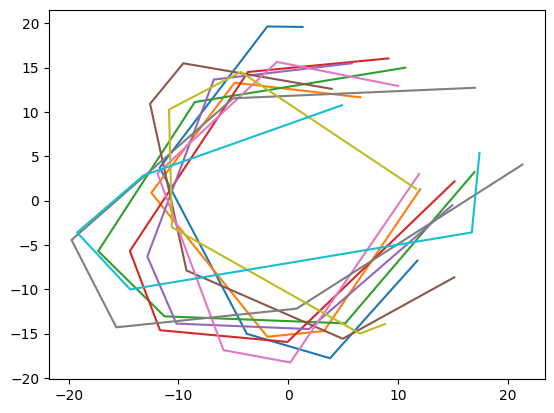

In [11]:
for i in range(10):
    plt.plot(centered_polygons[i][:,0], centered_polygons[i][:,1])

In [12]:
eigvals, eigvecs = np.linalg.eigh(cov)  # returns sorted (ascending) eigenvalues for symmetric matrices

# eigenvalues are in ascending order (smallest first), so:
minor_idx = 0
major_idx = 1

# directions (unit vectors)
minor_dir = eigvecs[:, minor_idx]
major_dir = eigvecs[:, major_idx]

proj_major = [np.array(polygon).dot(major) for polygon, major in zip(polygons, major_dir)]
major_length = [major.max() - major.min() for major in proj_major]
        # minor_length = [minor.max() - minor.min() for minor in proj_minor]
len(major_length)

588

In [13]:
i = 5

centered_polygon = polygons[i]
centered_polygon.append(centered_polygon[0])
centered_polygon = np.array(centered_polygon) - np.array(pos_vertex[centre[i]])


In [14]:
def get_cell_aspect_ratios(list_vm):

    cells = list_vm[0].getVertexIndicesByType("centre")

    aspect_ratio = []
    for vm in list_vm:  
        polygons = getPolygonsCell(vm)
        centers  = itemgetter(*cells)(list_vm[0].getPositions(wrapped=True))

        centered_polygons = [np.array(polygon) - np.array(center) for polygon, center in zip(polygons, centers)]


        cov = [np.cov(polygon, rowvar=False, bias=False) for polygon in polygons]

        # eigen-decomposition
        eigvals, eigvecs = np.linalg.eigh(cov)  # returns sorted (ascending) eigenvalues for symmetric matrices

        # eigenvalues are in ascending order (smallest first), so:
        minor_idx = 0
        major_idx = 1

        # directions (unit vectors)
        minor_dir = eigvecs[:, minor_idx]
        major_dir = eigvecs[:, major_idx]

        proj_major = [np.array(polygon).dot(major) for polygon, major in zip(polygons, major_dir)]
        proj_minor = [np.array(polygon).dot(minor) for polygon, minor in zip(polygons, minor_dir)]

        major_length = np.array([major.max() - major.min() for major in proj_major])
        minor_length = np.array([minor.max() - minor.min() for minor in proj_minor])

        aspect_ratio.append(major_length / minor_length)

    return aspect_ratio



r = get_cell_aspect_ratios(list_vm)

(588,)


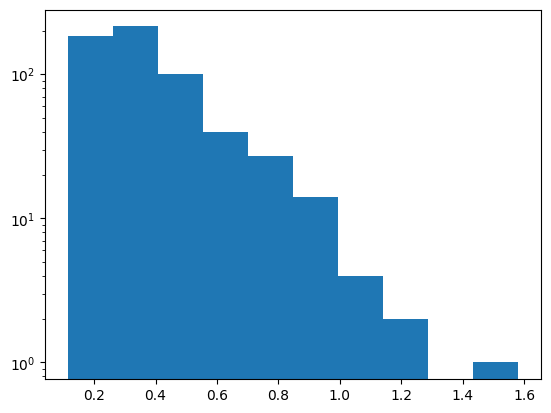

In [15]:
r = np.array(r)
print(np.shape(np.mean(r, axis=0)))
# plt.hist(r.ravel())
plt.hist(np.std(r, axis=0))
plt.yscale("log")

In [82]:
# plt.hist(np.mean(cell_speeds, axis=0), bins=20, density=True);
# plt.hist(cell_heights.ravel(), bins=20, density=True);
#plt.hist(np.mean(cell_heights, axis=0), bins=20, density=True);
#plt.hist(np.std(cell_heights, axis=0)/np.mean(cell_heights, axis=0), bins=20, density=True);
#plt.hist(np.std(cell_areas, axis=0)/np.mean(cell_areas, axis=0), bins=20, density=True);
#plt.hist(np.mean(cell_heights, axis=1), bins=20, density=True);


In [19]:
autocorr = VMAutocorrelationObject(out_path=filepath)
autocorr.log

State loaded from data/simulated/processed/nodivision_20251030_N42_L600_gamma24_v0100_taup1_eta2.autocorr.


{'t': {'hh': '2025/11/19_11:05',
  'AA': '2025/11/19_11:05',
  'VV': '2025/11/19_11:05',
  'vv': '2025/11/19_11:05'},
 'r': {'hh': '2025/11/19_11:05',
  'AA': '2025/11/19_11:05',
  'VV': '2025/11/19_11:05',
  'vv': '2025/11/19_11:05'}}

In [27]:
np.linspace(8, 19, 12).astype('str')

array(['8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0',
       '16.0', '17.0', '18.0', '19.0'], dtype='<U32')

In [24]:
def hist_to_curve(arr, bins=0, hist_range=None):
    ''' Returns histogram as a normalized curve '''
    if hist_range == None:
        hist_range = (np.ma.min(arr), np.ma.max(arr))

    if bins == 0:
        bins  = int(np.max(arr))

    y, x = np.histogram(arr, bins=bins, range=hist_range, density=True)

    return 0.5*(x[1:] + x[:-1]), y, bins

In [46]:
vm_list_1, _ = vm_output.load(f"data/simulated/raw/nodivision_20250919_N30_L64_Lambda100_v0100_taup400/nodivision_seed28.p")
# vm_list_2, _ = vm_output.load(f"data/simulated/raw/nodivision_20250919_N30_L64_Lambda100_v0100_taup200/nodivision_seed188.p")
# vm_list_3, _ = vm_output.load(f"data/simulated/raw/nodivision_20250919_N30_L64_Lambda100_v0100_taup300/nodivision_seed190.p")
# vm_list_4, _ = vm_output.load(f"data/simulated/raw/nodivision_20250919_N30_L64_Lambda100_v0100_taup400/nodivision_seed28.p")

In [ ]:
y_h = []
y_A = []
y_V = []

for vm_list in tqdm([vm_list_1, vm_list_2, vm_list_3, vm_list_4]):



    heights = vm_output.get_cell_heights(vm_list)
    volumes = vm_output.get_cell_volumes(vm_list)
    areas = volumes / heights

    x_h, y_h_tmp, _ = hist_to_curve(heights.flatten(), bins=40, hist_range=(0, 1))
    x_A, y_A_tmp, _ = hist_to_curve(areas.flatten(),   bins=40, hist_range=(0, 30))
    x_V, y_V_tmp, _ = hist_to_curve(volumes.flatten(), bins=20, hist_range=(0, 12))

    y_h.append(y_h_tmp)
    y_A.append(y_A_tmp)
    y_V.append(y_V_tmp)


100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


In [76]:
L = 64
N = 30
Atot = L**2 * np.sqrt(3) / 2
Ncell = N**2 / 3

r0 = 1 / 7.22
A0 = 1 / (7.22)**2
V0 = 1 / (7.22)**3

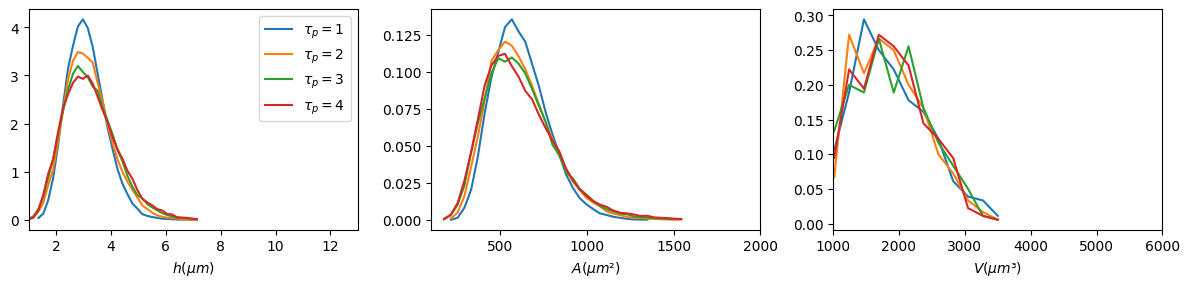

In [79]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

for i in range(4):
    ax[0].plot(x_h[y_h[i] > 0] / r0, y_h[i][y_h[i] > 0], label=rf"$\tau_p = {(i+1)}$")
    ax[1].plot(x_A[y_A[i] > 0] / A0, y_A[i][y_A[i] > 0])
    ax[2].plot(x_V[y_V[i] > 0] / V0, y_V[i][y_V[i] > 0])


ax[0].set(xlabel=r"$h (µm)$", xlim=(1, 13))
ax[1].set(xlabel=r"$A (µm²)$", xlim=(100, 2000))
ax[2].set(xlabel=r"$V (µm³)$", xlim=(1000, 6000))
ax[0].legend()
fig.tight_layout()
fig.savefig("size_distributions_preliminary_exp_units.png")

In [ ]:
L = 64
N = 30
Atot = L**2 * np.sqrt(3) / 2
Ncell = N**2 / 3
10**6*Ncell / (Atot * 7.22**2)

252.7

In [ ]:
corr = VMAutocorrelationObject(out_path=filepath, path_addition="../../")

In [14]:
corr.out_path, corr.in_path

('data/simulated/processed/nodivision_20250919_N30_L64_Lambda100_v0100_taup100/nodivision_seed112.autocorr',
 'data/simulated/raw/nodivision_20250919_N30_L64_Lambda100_v0100_taup100/nodivision_seed112.p')

In [37]:
np.arccos(init_vm[0].getCentreVelocities()[0][0]), np.arcsin(init_vm[0].getCentreVelocities()[0][1]),

(np.float64(1.4290568802817363), np.float64(-0.5088646642357719))

In [33]:
np.cos(np.pi), np.arccos(-1)

(np.float64(-1.0), np.float64(3.141592653589793))

In [47]:
list_vm = vm_list_1
cells = list_vm[0].getVertexIndicesByType("centre")

neighbours_matrix = np.zeros([len(list_vm), max(cells)+1, max(cells)+1])

for frame in range(len(list_vm)):
    for cell in cells:
        neighbours = list_vm[frame].getNeighbouringCellIndices(cell)
        neighbours_matrix[frame, cell, neighbours] = 1

(array([  2.,  75., 153.,  61.,   9.]),
 array([3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <BarContainer object of 5 artists>)

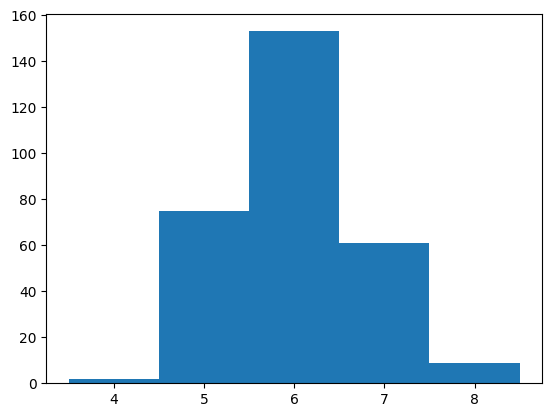

In [57]:
plt.hist(np.sum(neighbours_matrix[-1], axis=1), range=(3.5,8.5), bins=5)

In [ ]:
pos = vm_output.get_cell_positions(list_vm)


(200, 300, 2)

In [75]:
q = 2*np.pi

dr = np.sqrt(np.sum((pos[1] - pos[0])**2, axis=1))
np.mean(np.real(np.exp(1j*q*dr)))

np.float64(0.5919475288419386)

In [76]:
dr = np.sqrt(np.sum((pos[2] - pos[0])**2, axis=1))
np.mean(np.real(np.exp(1j*q*dr)))

np.float64(-0.025343663585399495)